In [1]:
!pip install datasets==2.13.1
!pip install spacy==3.6.1
!pip install torch==2.0.1
!pip install torchtext==0.15.2
!python -m spacy download en_core_web_sm

In [2]:
import os
import sys
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

from datasets import load_dataset

In [3]:
def regularized_f1(train_f1, dev_f1, threshold=0.0015):
    """
    Returns development F1 if overfitting is below threshold, otherwise 0.
    """
    return dev_f1 if (train_f1 - dev_f1) < threshold else 0


def save_metrics(*args, path, fname):
    if not os.path.exists(path):
        os.makedirs(path)
    if not os.path.isfile(path + fname):
        with open(path + fname, "w", newline="\n") as f:
            f.write(
                ",".join(
                    [
                        "config",
                        "epoch",
                        "train_loss",
                        "train_acc",
                        "train_f1",
                        "val_loss",
                        "val_acc",
                        "val_f1",
                    ]
                )
            )
            f.write("\n")
    if args:
        with open(path + fname, "a", newline="\n") as f:
            f.write(",".join([str(arg) for arg in args]))
            f.write("\n")

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(1234)

In [4]:
VOCAB_SIZE = 20_000
BATCH_SIZE = 32
NUM_EPOCHS = 15
MAX_LEN = 256
LEARNING_RATE = 1e-4

In [5]:
dataset = load_dataset('imdb')

# the middle slice 10% to 85% is for training
train_data = load_dataset("imdb", split="train[10%:85%]")

# two remaining ends for validation
dev_data =  load_dataset("imdb", split="train[:10%]+train[85%:]")

# dataset also contains a test data for testing
test_data = load_dataset("imdb", split="test")

In [6]:
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")

# Define vocabulary
train_text_iterator = (tokenizer(text) for text in train_data["text"])
vocab = build_vocab_from_iterator(
    train_text_iterator, specials=["<UNK>", "<PAD>"], max_tokens=VOCAB_SIZE
)
vocab.set_default_index(vocab["<UNK>"])

In [7]:
def index_data(data):
    return [vocab(tokenizer(ex['text']))[:MAX_LEN] for ex in data]

train_idx = index_data(train_data)
dev_idx = index_data(dev_data)
test_idx = index_data(test_data)

In [8]:
class ImdbDataset(Dataset):
    def __init__(self, seq, lbl):
        # initializing the sequence and label vectors
        self.sequence = seq
        self.label = lbl

    def __getitem__(self, idx):
        sequence = torch.LongTensor(self.sequence[idx])  # Convert to LongTensor
        label = torch.tensor(self.label[idx], dtype=torch.long)  # Convert label to tensor with dtype

        return {'sequence': sequence, 'label': label}

    def __len__(self):
        # returns the length of the seqence
        return len(self.sequence)

In [9]:
# we can get the text sequence and labels from our train_data
train_set = ImdbDataset(train_idx, train_data['label'])

In [10]:
class GroupedSampler(Sampler):
    def __init__(self, seqs, batch_size):
        # Obtain the lengths of sequences and map them to their indices
        self.seqs = [(i, len(seq)) for i, seq in enumerate(seqs)]
        self.batch_size = batch_size

    def __iter__(self):
        random.shuffle(self.seqs)
        batches = []

        # Iterate to construct a batch
        for i in range(0, len(self.seqs), self.batch_size * 100):
            batch = []

            # Create a batch, stopping at len(self.seqs) in case it's not a multiple of batch_size*100
            for j in range(i, min(i + self.batch_size * 100, len(self.seqs))):
                batch.append(self.seqs[j])

            # Sort based on length, by default it's ascending
            batch.sort(key=lambda x: x[1])

            batches.append(batch)

        index_batches = [[index for index, _ in sorted_batch] for sorted_batch in batches]

        return iter(index_batches)

    def __len__(self):
        return len(self.seqs)


In [11]:
train_grouped_sampler = GroupedSampler(train_set, BATCH_SIZE)
train_sampler = BatchSampler(train_grouped_sampler, batch_size=BATCH_SIZE, drop_last=False)

In [12]:
def collate_batch(batch):
    """
    Collate a batch of examples into a dictionary of tensors.
    """
    # get the sequences and labels
    sequence = [example['sequence'] for example in batch]
    labels = torch.tensor([example['label'] for example in batch], dtype=torch.long)  # Convert labels to tensor with dtype

    # pad the sequences
    sequence = pad_sequence(sequence, batch_first=True, padding_value=1)

    # get the lengths of the original sequences
    lengths = torch.tensor([len(example['sequence']) for example in batch])

    # return the batch as a dictionary
    return {'sequence': sequence, 'label': labels, 'length': lengths}

In [13]:
# Create dev and test sets
dev_set = ImdbDataset(dev_idx, dev_data['label'])
test_set = ImdbDataset(test_idx, test_data['label'])

# Create DataLoader with train_sampler
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, collate_fn=collate_batch, num_workers=2)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch, num_workers=2)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch, num_workers=2)

In [14]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_size, hidden_size, dropout, num_classes=2):
        super(BiLSTM, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
        self.embedding_dropout = nn.Dropout(dropout)

        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=rnn_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        # Linear layer for dimensionality reduction
        self.reduce_dim = nn.Linear(2 * rnn_size, hidden_size)
        self.reduce_dim_activation = nn.ReLU()
        self.reduce_dim_dropout = nn.Dropout(dropout)

        # Linear layer for binary classification (1 or 2 output neurons)
        self.classification = nn.Linear(hidden_size, num_classes)

    def forward(self, seq, lengths):
        # Embedding layer
        embedded_seq = self.embedding(seq)
        embedded_seq = self.embedding_dropout(embedded_seq)

        # Pack the embedded sequence for variable-length sequences
        packed_seq = pack_padded_sequence(embedded_seq, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # LSTM layer
        packed_output, _ = self.lstm(packed_seq)

        # Unpack the sequence
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Pooling - average over time steps
        pooled_output = torch.mean(output, dim=1)

        # Linear layers
        reduced_output = self.reduce_dim(pooled_output)
        reduced_output = self.reduce_dim_activation(reduced_output)
        reduced_output = self.reduce_dim_dropout(reduced_output)

        classification_output = self.classification(reduced_output)

        return classification_output

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
def process(model, loader, criterion, optim=None, device="cpu", is_train=True):
    # Set the model to training mode if is_train is True, else to evaluation mode
    model.train() if is_train else model.eval()

    # Initialize lists to store predictions and labels for F1 and accuracy calculations
    all_preds = []
    all_labels = []

    # Initialize loss and accuracy variables
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    progress_bar = tqdm(loader, unit="batches", file=sys.stdout, desc="Training" if is_train else "Evaluation")
    # Iterate through the data loader
    for batch in progress_bar:
        # Move sequences and labels to the specified device

        sequence = batch['sequence'].to(device)
        labels = batch['label'].to(device)

        # Calculate the model's predictions
        with torch.set_grad_enabled(is_train):
            outputs = model(sequence, batch['length'].to(device))

        # Compute the loss
        loss = criterion(outputs, labels)

        # If optimizer is provided, perform backpropagation and update model weights
        if optim is not None and is_train:
            optim.zero_grad()
            loss.backward()
            optim.step()

        # Calculate the number of correctly classified samples
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels).item()
        total_samples += labels.size(0)

        # Append predictions and labels for F1 and accuracy calculations
        all_preds.extend(preds.cpu())
        all_labels.extend(labels.cpu())

        # Update the loss in the progress bar description
        progress_bar.set_description("Training" if is_train else "Evaluation")
        progress_bar.set_postfix(loss=loss.item())

        # Update the total loss
        total_loss += loss.item()

    # Calculate the average loss and accuracy
    average_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average="binary")

    return average_loss, accuracy, f1

In [17]:
configs = {
    "config1": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 10,
        "hidden_size": 10,
        "rnn_size": 10,
        "dropout": 0.5
    },
    "config2": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 64,
        "hidden_size": 32,
        "rnn_size": 256,
        "dropout": 0.5
    },
    "config3": {
        "vocab_size": VOCAB_SIZE,
        "embedding_dim": 300,
        "hidden_size": 256,
        "rnn_size": 256,
        "dropout": 0.5
    }
}

In [18]:
criterion = nn.CrossEntropyLoss()

In [19]:
def main(wd = 0, lr = LEARNING_RATE, op='adam', logging_file= 'results.csv'):
    path = './'

    if os.path.exists(logging_file):
        os.remove(logging_file)

    best_config = None
    best_f1 = 0

    print(f"device: {device}")

    print(f"optimiser: {op}")
    for config_name, configuration in configs.items():
        model = BiLSTM(
            configuration["vocab_size"],
            configuration["embedding_dim"],
            configuration["rnn_size"],
            configuration["hidden_size"],
            configuration["dropout"]
        )
        model.to(device)  # Move model to device

        if op == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=wd) # Overfitting
        elif op == "sgd":
            optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=wd) # Not good
        elif op == "adagrad":
            optimizer = torch.optim.Adagrad(model.parameters(), lr=LEARNING_RATE, lr_decay=0, weight_decay=wd, initial_accumulator_value=0, eps=1e-10) # Best ?
        elif op == "adadelta":
            optimizer = torch.optim.Adadelta(model.parameters(), lr=LEARNING_RATE, rho=0.9, eps=1e-06, weight_decay=wd) # Not good
        elif op == "adamax":
            optimizer = optim.Adamax(model.parameters(), lr=LEARNING_RATE, weight_decay=wd) # Working ? Overfits
        elif op == "rmsprop":
            optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=wd) # Overfits

        highest_f1 = -100
        consecutive_below = 0

        for epoch in range(NUM_EPOCHS):

            model.train()
            if op:
                train_loss, train_acc, train_f1 = process(model, train_loader, criterion, device=device, optim=optimizer)
            else:
                train_loss, train_acc, train_f1 = process(model, train_loader, criterion, device=device)

            model.eval()
            with torch.no_grad():
                val_loss, val_acc, val_f1 = process(model, dev_loader, criterion, is_train=False, device=device)

            config_num = int(config_name[6:7])
            save_metrics(
                config_num,
                epoch + 1,
                train_loss,
                train_acc,
                train_f1,
                val_loss,
                val_acc,
                val_f1,
                path=path,
                fname=logging_file
            )


            if val_f1 > highest_f1:
                highest_f1 = val_f1
                consecutive_below = 0
                if val_f1 > best_f1:
                    best_f1 = val_f1
                    best_config = config_num + 1
                    torch.save(model.state_dict(), f'best_model_config{best_config}.pt')
            else:
                consecutive_below += 1
                if consecutive_below >= 3:
                    print(f"\033[34mConfig {config_num}, Epoch {epoch + 1}: Train F1 {train_f1:.4f}, Val F1 {val_f1:.4f}\033[0m")
                    break

            print(f"\033[34mConfig {config_num}, Epoch {epoch + 1}: Train F1 {train_f1:.4f}, Val F1 {val_f1:.4f}\033[0m")
    return best_config
if __name__ == "__main__":
    best_config = main()

device: cuda
optimiser: adam
Evaluation: 100%|██████████| 196/196 [00:04<00:00, 39.53batches/s, loss=0.766]
Config 1, Epoch 1: Train F1 0.0274, Val F1 0.0000
Evaluation: 100%|██████████| 196/196 [00:05<00:00, 35.70batches/s, loss=0.753]
Config 1, Epoch 2: Train F1 0.0313, Val F1 0.0000
Evaluation: 100%|██████████| 196/196 [00:04<00:00, 48.27batches/s, loss=0.748]
Config 1, Epoch 3: Train F1 0.0247, Val F1 0.0000
Evaluation: 100%|██████████| 196/196 [00:04<00:00, 39.49batches/s, loss=0.74]
Config 1, Epoch 4: Train F1 0.0332, Val F1 0.0000
Evaluation: 100%|██████████| 196/196 [00:05<00:00, 35.23batches/s, loss=0.0934]
Config 2, Epoch 1: Train F1 0.8820, Val F1 0.7500
Evaluation: 100%|██████████| 196/196 [00:08<00:00, 22.50batches/s, loss=0.321]
Config 2, Epoch 2: Train F1 0.5818, Val F1 0.7500
Evaluation: 100%|██████████| 196/196 [00:05<00:00, 32.96batches/s, loss=0.403]
Config 2, Epoch 3: Train F1 0.5669, Val F1 0.7500
Evaluation: 100%|██████████| 196/196 [00:04<00:00, 41.50batches/s, l

In [20]:
df = pd.read_csv('results.csv')
df

,config,epoch,train_loss,train_acc,train_f1,val_loss,val_acc,val_f1
0,1,1,0.696881,0.538773,0.027440,0.709181,0.4,0.00
1,1,2,0.694737,0.527253,0.031257,0.705652,0.4,0.00
2,1,3,0.694749,0.527733,0.024672,0.704317,0.4,0.00
3,1,4,0.693265,0.530987,0.033201,0.702125,0.4,0.00
4,2,1,0.494857,0.900267,0.882004,2.184608,0.6,0.75
5,2,2,0.760681,0.595413,0.581808,0.825669,0.6,0.75
6,2,3,0.692663,0.593867,0.566862,0.722152,0.6,0.75
7,2,4,0.668044,0.590507,0.569619,0.809344,0.6,0.75
8,3,1,0.370530,0.911253,0.896736,3.976732,0.6,0.75
9,3,2,0.489095,0.863200,0.850759,2.425952,0.6,0.75


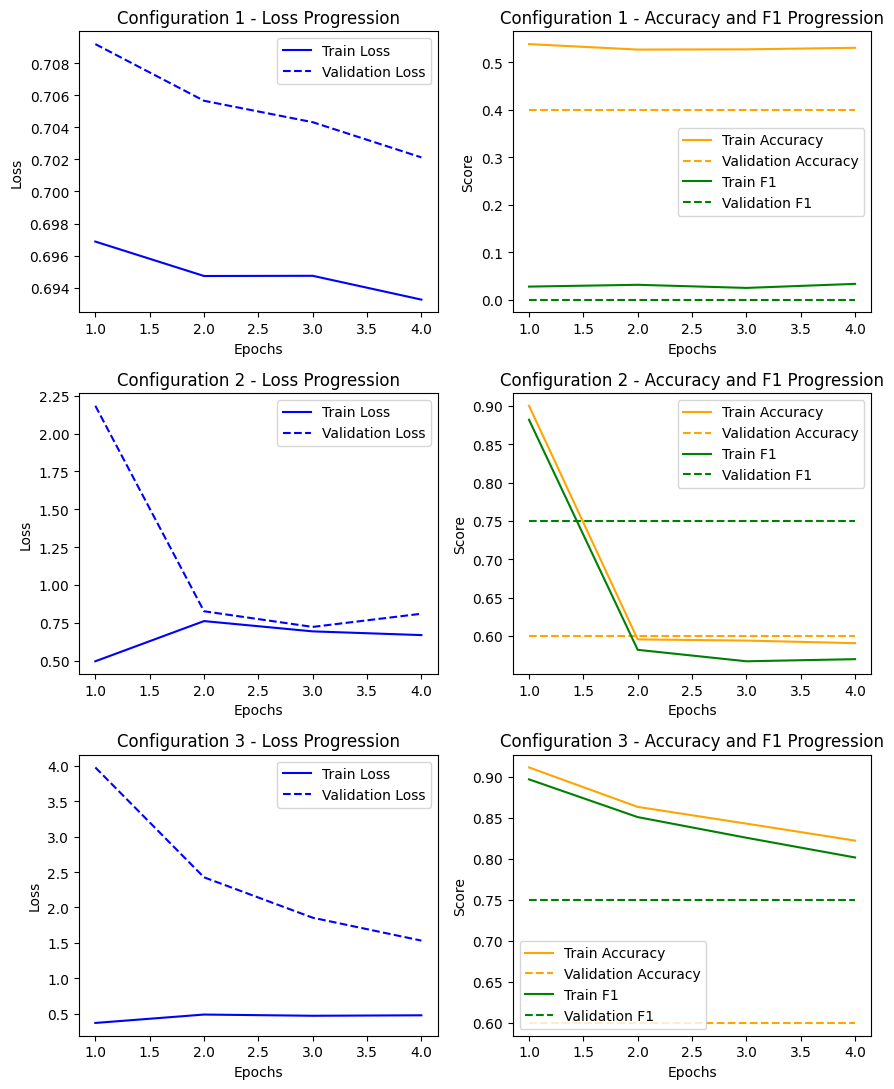

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(9, 11))

# Define configurations
configurations = [1, 2, 3]  # Assuming there are 3 configurations

# Iterate through configurations
for config_num in configurations:
    config_df = df[df['config'] == config_num]
    epochs = config_df['epoch']

    # Plot 1: Loss Progression
    ax[config_num-1, 0].plot(epochs, config_df['train_loss'], label='Train Loss', color='blue')
    ax[config_num-1, 0].plot(epochs, config_df['val_loss'], label='Validation Loss', color='blue', linestyle='dashed')
    ax[config_num-1, 0].set_xlabel('Epochs')
    ax[config_num-1, 0].set_ylabel('Loss')
    ax[config_num-1, 0].set_title(f'Configuration {config_num} - Loss Progression')
    ax[config_num-1, 0].legend()

    # Plot 2: Accuracy and F1 Progression
    ax[config_num-1, 1].plot(epochs, config_df['train_acc'], label='Train Accuracy', color='orange')
    ax[config_num-1, 1].plot(epochs, config_df['val_acc'], label='Validation Accuracy', color='orange', linestyle='dashed')
    ax[config_num-1, 1].plot(epochs, config_df['train_f1'], label='Train F1', color='green')
    ax[config_num-1, 1].plot(epochs, config_df['val_f1'], label='Validation F1', color='green', linestyle='dashed')
    ax[config_num-1, 1].set_xlabel('Epochs')
    ax[config_num-1, 1].set_ylabel('Score')
    ax[config_num-1, 1].set_title(f'Configuration {config_num} - Accuracy and F1 Progression')
    ax[config_num-1, 1].legend()

# Show the plots
plt.tight_layout()
plt.show()